In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import os
import os.path as path
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
sns.reset_orig()
from IPython.display import display, HTML


%matplotlib inline
%load_ext autoreload

%autoreload 2
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
matplotlib.rcParams["font.size"] = "30"
matplotlib.rcParams["font.family"] = "Times New Roman"
sns.set(font_scale=2)

pd.set_option('display.max_rows', 20)

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

# Preparation de la base de données

## scores et questionnaires

In [2]:
df_phase_1 = pd.read_csv('Data/df_stats_phase_1.csv')

df_phase_1 = df_phase_1[['Participant', 'Game', 'score_performance', 'Engagement ', 'Surcharge',
       'Sous-stimulation']].rename(columns={'Participant':'participant', 'Game':'session', 'Engagement ':'Engagement'})
df_phase_1['niveau_de_complexite'] = 4
df_phase_1['phase'] = 1
df_phase_1['test'] = df_phase_1['session'] > 20


In [3]:
df_phase_2 = pd.read_csv('Data/df_stats_phase_2.csv')
df_phase_2 = df_phase_2[['participant', 'essais', 'Nb de parties' , 'score_performance', 
       "J'étais sous stimulé par cette tâche.",
       "J'étais surchargé par cette tâche.",
       "J'ai déployé beaucoup d'efforts dans la présente tâche.",
       "C'était important pour moi de performer à cette tâche.",
       "Je me suis soucié d'atteindre mes objectifs",
       "J'étais engagé envers mes objectifs.",]].copy()

df_phase_2['Engagement'] = (df_phase_2["J'ai déployé beaucoup d'efforts dans la présente tâche."] + 
                            df_phase_2["C'était important pour moi de performer à cette tâche."] +
                            df_phase_2["Je me suis soucié d'atteindre mes objectifs"] +
                            df_phase_2["J'étais engagé envers mes objectifs."]
                           )
df_phase_2 = df_phase_2.rename(columns={"J'étais sous stimulé par cette tâche.":"Sous-stimulation", "J'étais surchargé par cette tâche.":"Surcharge"})
df_phase_2 = df_phase_2.drop([
       "J'ai déployé beaucoup d'efforts dans la présente tâche.",
       "C'était important pour moi de performer à cette tâche.",
       "Je me suis soucié d'atteindre mes objectifs",
       "J'étais engagé envers mes objectifs.",], axis=1)

def essais_to_compl(val):
    if val < 6:
        return 1
    if 6 <= val < 11:
        return 2
    if 11 <= val < 16:
        return 3
    if 16 <= val < 21:
        return 4
    if val >=21: # même complexité que 16-20
        return 4
    
df_phase_2['niveau_de_complexite'] = df_phase_2['Nb de parties'].apply(essais_to_compl)
df_phase_2 = df_phase_2.rename(columns={'Nb de parties':'session'}).drop('essais', axis=1)
df_phase_2['test'] = df_phase_2['session'] > 20
df_phase_2['phase'] = 2

In [4]:
df = pd.concat([df_phase_1, df_phase_2])
df.to_csv('Data/compilation_score.csv', index=False, encoding='UTF-8')
df['participant'] = df['participant'] + (df['phase']-1)*100

df['stand_score_performance'] = df.groupby('participant').score_performance.transform(lambda x: (x - x[16:].mean()) / x[16:].std())
df['participant'] = df['participant'] - (df['phase']-1)*100
df['session_id'] = (df.session + df.participant * 100 + df.phase*10000).astype(int)
df = df.set_index('session_id')

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


## Bio data

In [ ]:
datapath = 'Data/Experience {}'
dfs = []
def min_max(se):
    return se.max()-se.min()

for file in ['BioSummaryRaw.csv', 'HeartRateVariabilityFeature.csv', 'EyeFeature.csv']:
    df_biosummary_phase_1 = pd.read_csv(path.join(datapath.format(1), file)).iloc[:, 1:].copy()
    df_biosummary_phase_1['phase'] = 1
    df_biosummary_phase_2 = pd.read_csv(path.join(datapath.format(2), file)).iloc[:, 1:].copy()
    df_biosummary_phase_2['phase'] = 2
    df_biosummary = pd.concat([df_biosummary_phase_1, df_biosummary_phase_2])
    df_biosummary = df_biosummary.rename(columns={'game':'session'})
    if 'HeartRateConfidenceInPercentage' in df_biosummary.columns:
        df_biosummary = df_biosummary[df_biosummary.HeartRateConfidenceInPercentage>96]
    if 'HeartRateVariabilityInMillisecond' in df_biosummary.columns:
        df_biosummary = df_biosummary[df_biosummary.HeartRateVariabilityInMillisecond<60000]
    df_biosummary['session_id'] = (df_biosummary.session + df_biosummary.participant * 100 + df_biosummary.phase*10000).astype(int)
    df_biosummary = df_biosummary.drop(['session','participant', 'phase'], axis=1)
    df_biosummary = df_biosummary.groupby('session_id').agg(['mean', 'std', 'min', 'max', min_max])
    dfs.append(df_biosummary)
df_bio = pd.concat(dfs, axis=1)

In [ ]:
df_all = pd.concat((df, df_bio), axis=1)

In [ ]:
df_all.to_csv('Data/df_stats_bio_all_phase.csv')

# Analyse

In [6]:
df_all = pd.read_csv('Data/df_stats_bio_all_phase.csv')
df_all['stand_score_performance'] = df_all.groupby(('participant', 'niveau_de_complexite')).score_performance.transform(lambda se: (se - se.iloc[-4:].mean())/se.iloc[-4:].std())

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  from ipykernel import kernelapp as app


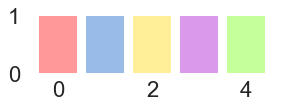

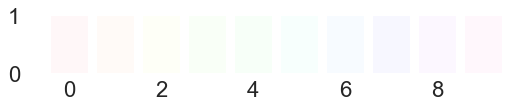

In [7]:
# Colors
fig = plt.figure(figsize=(4, 1), dpi=80)
cmap = matplotlib.cm.get_cmap('prism')
colors = [(*cmap(x)[:3], 0.4) for x in [0.1, 0.25, 0.5, 0.75, 0.9]]
plt.bar(range(len(colors)), [1 for _ in range(len(colors))], color=colors)
plt.gca().set_facecolor('white')
plt.show()

fig = plt.figure(figsize=(8, 1), dpi=80)
cmap2 = matplotlib.cm.get_cmap('gist_rainbow')
colors2 = [(*cmap2(x)[:3], 0.03) for x in np.linspace(0, 1, 10)]
plt.bar(range(len(colors2)), [1 for _ in range(len(colors2))], color=colors2)
plt.gca().set_facecolor('white')
plt.show()

FT_color = colors2[4]
CPT_color = colors2[7]

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


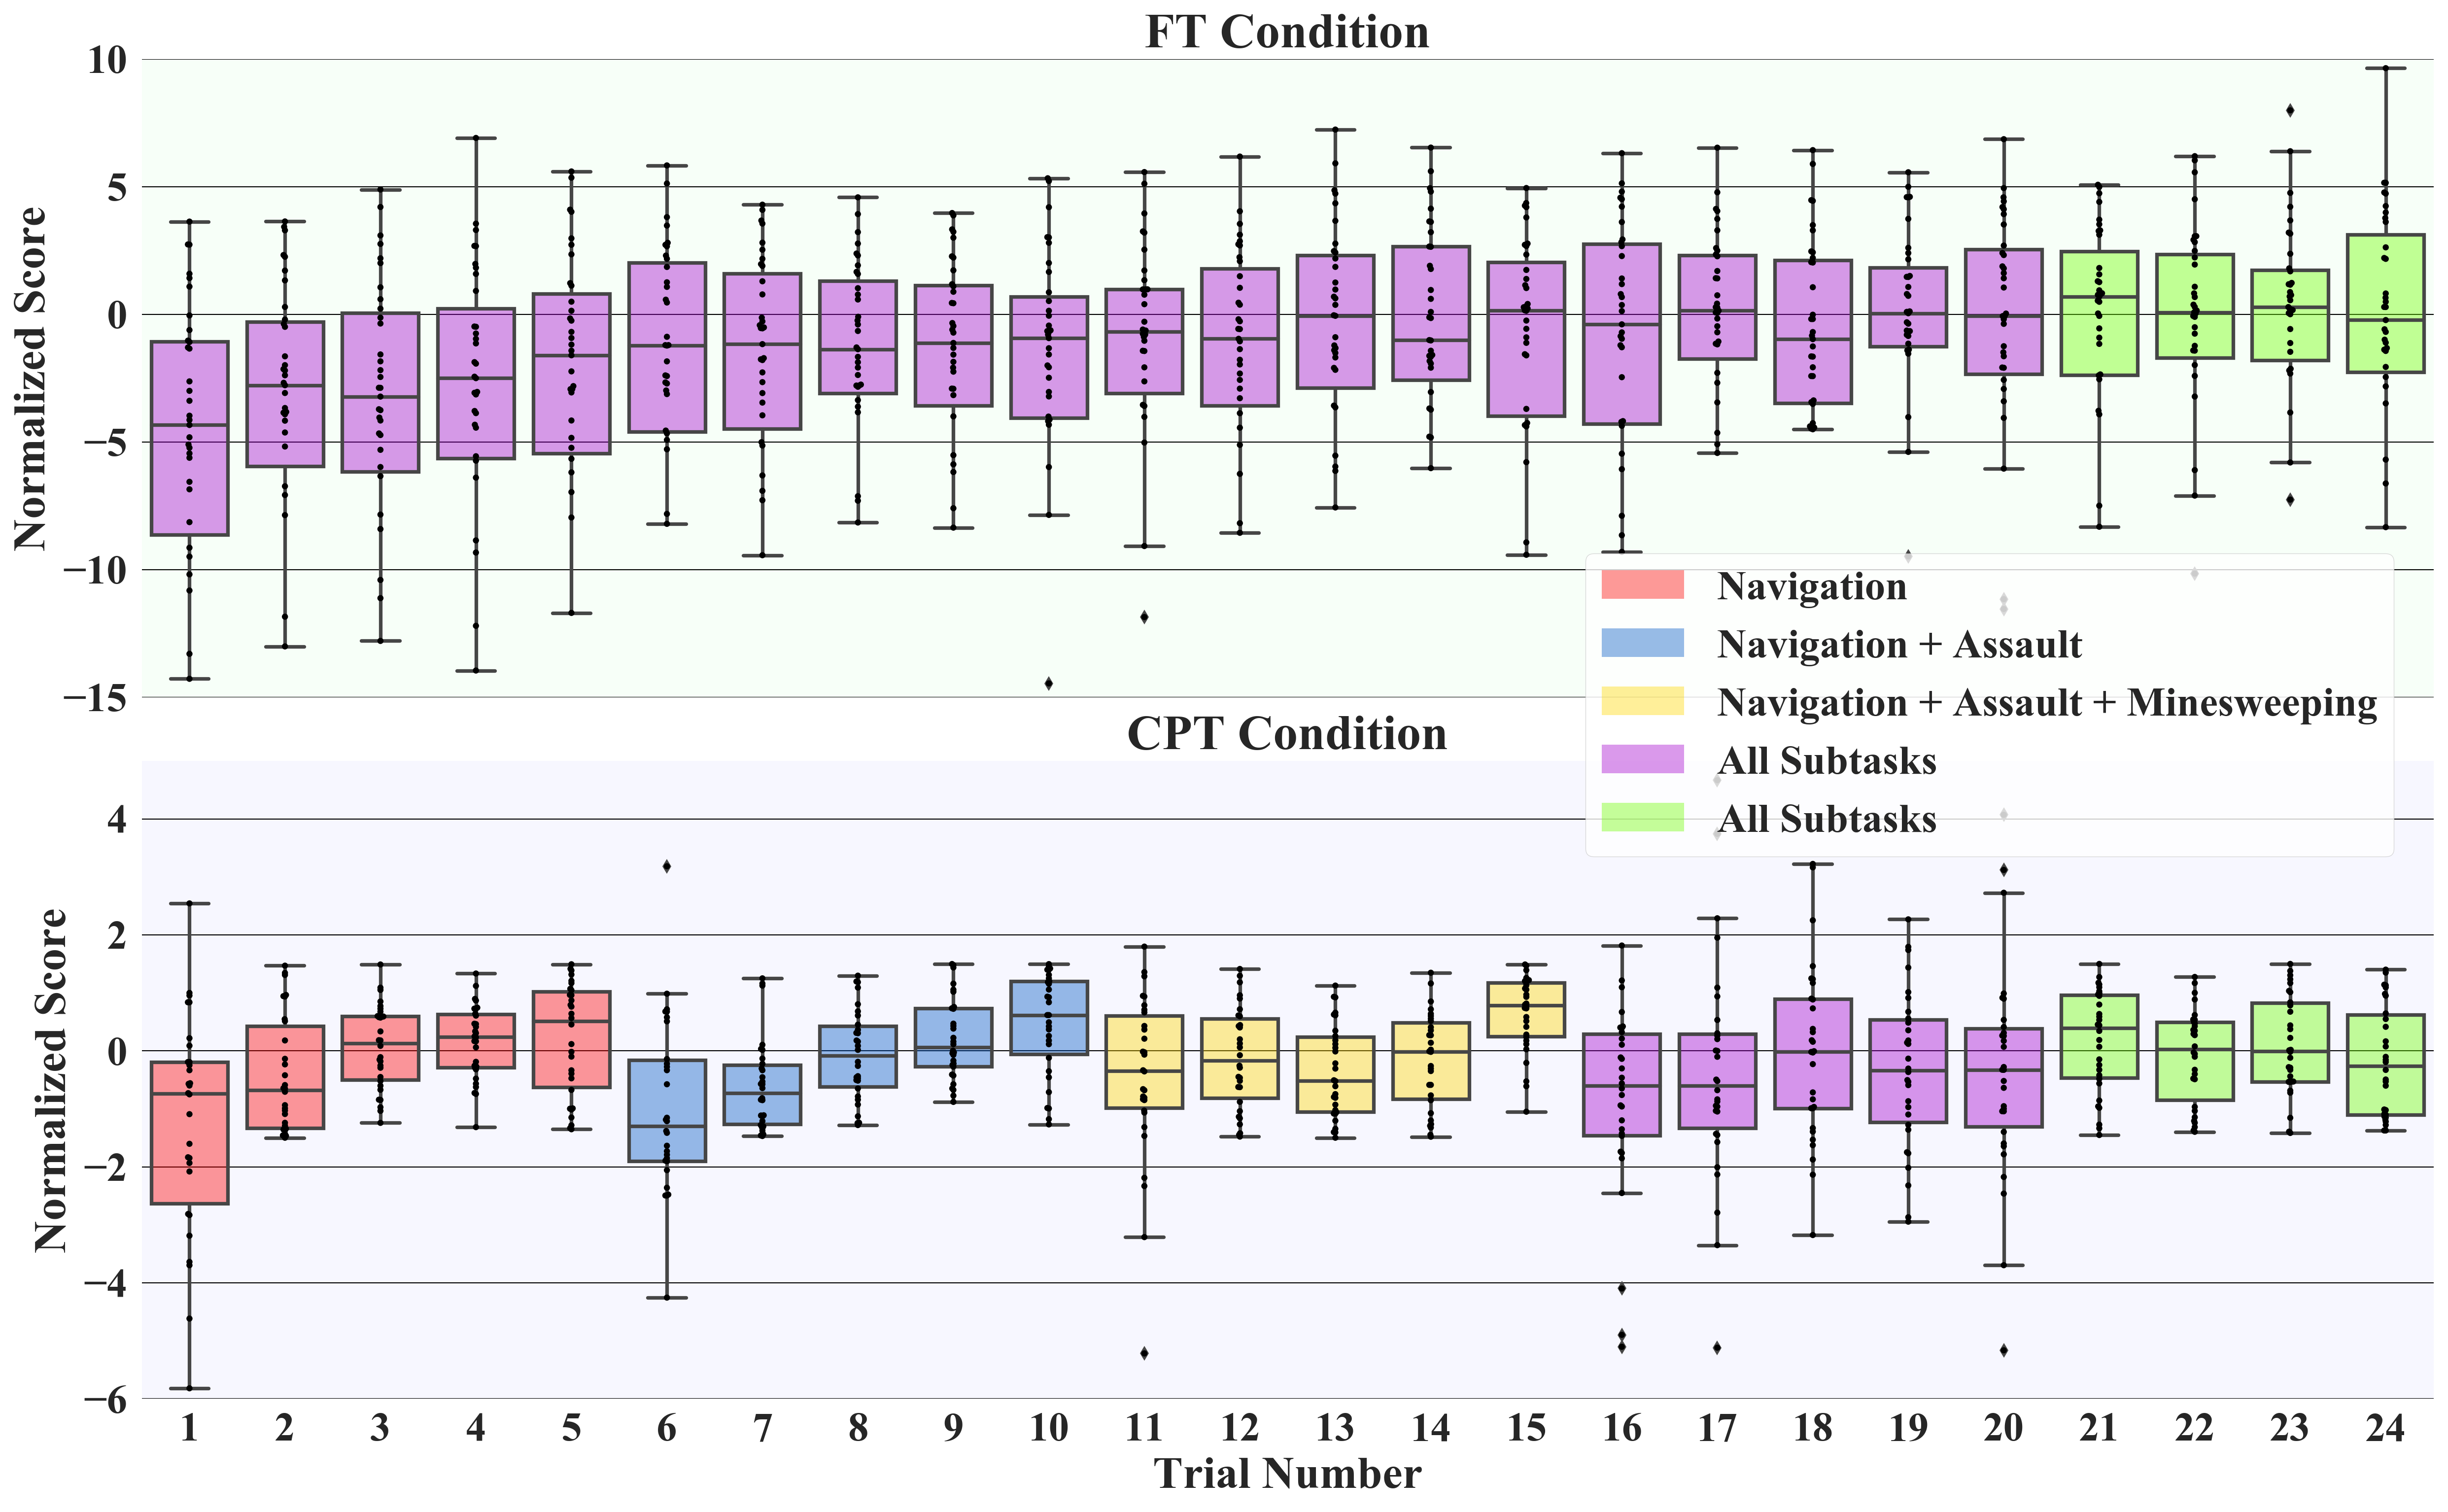

In [8]:
# Performance Phase 1
sns.set_style({'legend.frameon':True})
fig = plt.figure(num=None, figsize=(20, 12), dpi=300, facecolor='w', edgecolor='k')
plt.rcParams["font.family"] = "Times New Roman"
plt.subplot(2 , 1, 1)

ax = sns.boxplot(x='session', y='stand_score_performance', data=df_all[df_all.phase==1],)
for idx, patch in enumerate(ax.artists):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor(colors[idx//20 + 3])
sns.swarmplot(x='session', y='stand_score_performance', data=df_all[df_all.phase==1], color='.0', size=3)
plt.axis(ymin=-15, ymax=10)
ax.set_facecolor(FT_color)
ax.grid(color='k', linestyle='-', linewidth=0.5, axis='y')
plt.xlabel('')
# make these tick labels invisible
plt.setp(ax.get_xticklabels(), visible=False)
plt.tick_params(axis='y')
plt.ylabel('Normalized Score')
plt.title('FT Condition')

# Performance Phase 2
plt.subplot(2 , 1, 2, sharex=ax)
ax = sns.boxplot(x='session', y='stand_score_performance', data=df_all[df_all.phase==2],)
for idx, patch in enumerate(ax.artists):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor(colors[idx//5])
sns.swarmplot(x='session', y='stand_score_performance', data=df_all[df_all.phase==2], color='.0', size=3)
plt.axis(ymin=-6, ymax=5)
ax.set_facecolor(CPT_color)
ax.grid(color='k', linestyle='-', linewidth=0.5, axis='y')
plt.xlabel('Trial Number')
plt.ylabel('Normalized Score')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.1)
plt.title('CPT Condition')

legend = plt.legend([plt.Rectangle((0, 0), 1, 1, fc=colors[0]),
           plt.Rectangle((0, 0), 1, 1, fc=colors[1]),
           plt.Rectangle((0, 0), 1, 1, fc=colors[2]),
           plt.Rectangle((0, 0), 1, 1, fc=colors[3]),
           plt.Rectangle((0, 0), 1, 1, fc=colors[4])]
           , ["Navigation", 'Navigation + Assault', 'Navigation + Assault + Minesweeping', 'All Subtasks', 'All Subtasks'],
           loc=(0.63, 0.85)
          )
legend.get_frame().set_facecolor('white')

fig.savefig('img/performance.png', format='png')
fig.savefig('img/performance.svg', format='svg')
plt.show()

In [9]:
## FRANCAIS
# Performance Phase 1
sns.set_style({'legend.frameon':True})
fig = plt.figure(num=None, figsize=(20, 12), dpi=600, facecolor='w', edgecolor='k')
plt.rcParams["font.family"] = "Times New Roman"
plt.subplot(2 , 1, 1)

ax = sns.boxplot(x='session', y='stand_score_performance', data=df_all[df_all.phase==1],)
for idx, patch in enumerate(ax.artists):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor(colors[idx//20 + 3])
sns.swarmplot(x='session', y='stand_score_performance', data=df_all[df_all.phase==1], color='.0', size=3)
plt.axis(ymin=-15, ymax=10)
ax.set_facecolor(FT_color)
ax.grid(color='k', linestyle='-', linewidth=0.5, axis='y')
plt.xlabel('')
# make these tick labels invisible
plt.setp(ax.get_xticklabels(), visible=False)
plt.tick_params(axis='y')
plt.ylabel('Pointage Normalisé')
plt.title('Condition TI')

# Performance Phase 2
plt.subplot(2 , 1, 2, sharex=ax)
ax = sns.boxplot(x='session', y='stand_score_performance', data=df_all[df_all.phase==2],)
for idx, patch in enumerate(ax.artists):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor(colors[idx//5])
sns.swarmplot(x='session', y='stand_score_performance', data=df_all[df_all.phase==2], color='.0', size=3)
plt.axis(ymin=-6, ymax=5)
ax.set_facecolor(CPT_color)
ax.grid(color='k', linestyle='-', linewidth=0.5, axis='y')
plt.xlabel("Nombre d'essais")
plt.ylabel('Pointage Normalisé')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.1)
plt.title('Condition TPPF')

legend = plt.legend([plt.Rectangle((0, 0), 1, 1, fc=colors[0]),
           plt.Rectangle((0, 0), 1, 1, fc=colors[1]),
           plt.Rectangle((0, 0), 1, 1, fc=colors[2]),
           plt.Rectangle((0, 0), 1, 1, fc=colors[3]),
           plt.Rectangle((0, 0), 1, 1, fc=colors[4])]
           , ["Navigation", 'Navigation + Défense', 'Navigation + Défense + Mines', 'Toutes tâches', 'Toutes tâches'],
           loc=(0.63, 0.85)
          )
legend.get_frame().set_facecolor('white')

fig.savefig('img/fr_performance.png', format='png')
fig.savefig('img/fr_performance.svg', format='svg')
plt.show()

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


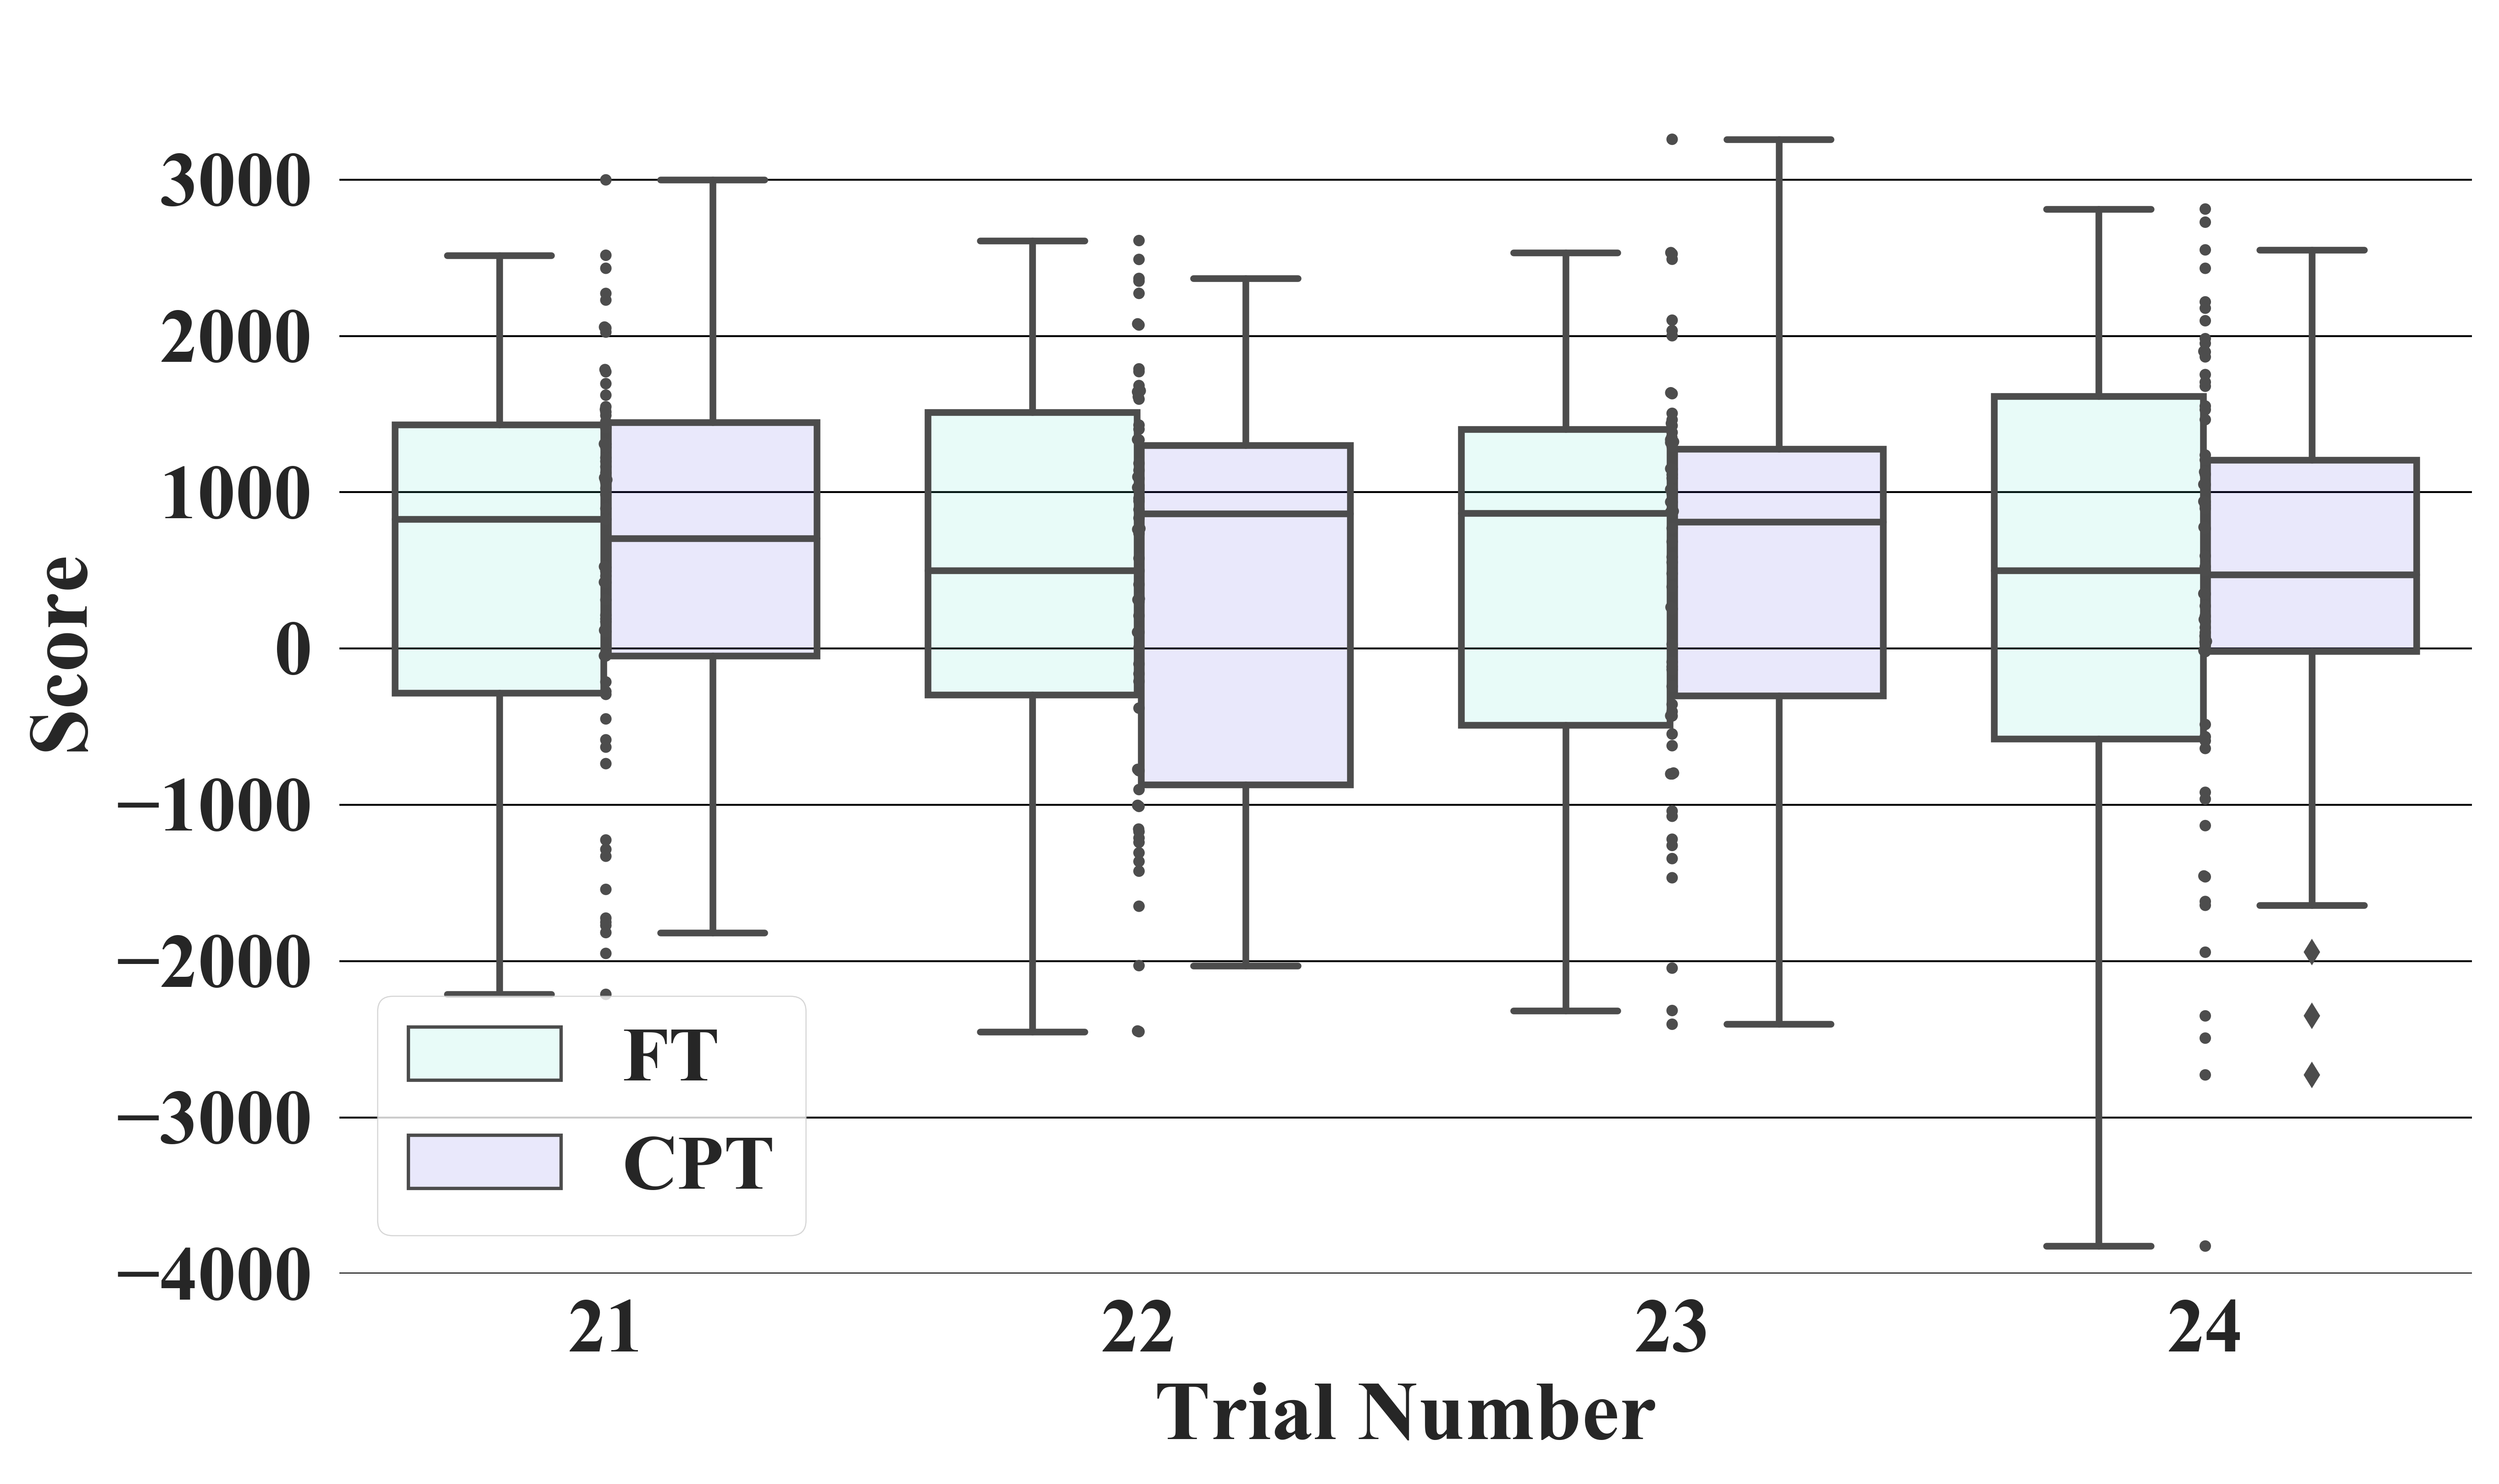

In [11]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=600, facecolor='w', edgecolor='k')
plt.rcParams["font.family"] = "Times New Roman"
ax = sns.boxplot(x="session", y="score_performance", hue="phase", data=df_all[df_all.session>20], palette={1:colors2[5], 2:colors2[7]})
for idx, patch in enumerate(ax.artists):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.1))
ax2 = sns.swarmplot(x='session', y='score_performance', hue="phase", data=df_all[df_all.session>20], color='.0', size=3, palette={1:'0.3', 2:'0.3'})
handles, labels = ax.get_legend_handles_labels()
for idx, patch in enumerate(handles[:2]):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.1))
ax.legend(handles[:2], ['FT', 'CPT'])
ax.get_legend().get_frame().set_facecolor('white')

ax.axis(ymin=-4000)
ax.set_facecolor('white')
ax.grid(color='k', linestyle='-', linewidth=0.5, axis='y')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Score')

fig.savefig('img/final_performance_comparison.png', format='png')
fig.savefig('img/final_performance_comparison.svg', format='svg')

plt.show()

# Engagement

In [12]:
df_participant_all_average = df_all.groupby(('phase', 'participant')).mean()
df_participant_4last_average = df_all[df_all.session>20].groupby(('phase', 'participant')).mean()

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  if __name__ == '__main__':
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  from ipykernel import kernelapp as app


## T-test

Moyenne par participant sur tout les sessions (trials)

In [13]:
t, p = scipy.stats.ttest_ind(df_participant_all_average.Engagement.loc[1], df_participant_all_average.Engagement.loc[2])
print('t = {}, p = {}'.format(t,p))

t = 0.05583361702802125, p = 0.9556510510108316


moyenne par participant sur les 4 dernieres sessions (trials)

In [14]:
t, p = scipy.stats.ttest_ind(df_participant_4last_average.Engagement.loc[1], df_participant_4last_average.Engagement.loc[2])
print('t = {}, p = {}'.format(t,p))

t = -1.6886731024776171, p = 0.09622643776942083


entre les deux distributions

In [15]:
t, p = scipy.stats.ttest_ind(df_all[df_all.phase==1].Engagement.dropna(), df_all[df_all.phase==2].Engagement.dropna())
print('t = {}, p = {}'.format(t,p))

t = 0.22673566800477463, p = 0.8206590537182419


In [16]:
print("FT M : {}, S : {}".format(df_all[df_all.phase==1].Engagement.dropna().mean(),df_all[df_all.phase==1].Engagement.dropna().std(), ))
print("CPT M : {}, S : {}".format(df_all[df_all.phase==2].Engagement.dropna().mean(),df_all[df_all.phase==2].Engagement.dropna().std(), ))

FT M : 16.731823599523242, S : 3.450754873987615
CPT M : 16.693055555555556, S : 3.2638205719216984


sur la distribution des 4 dernieres sessions

In [17]:
print("FT M : {}, S : {}".format(df_all[(df_all.phase==1) & (df_all.session>20)].Engagement.dropna().mean(),df_all[(df_all.phase==1) & (df_all.session>20)].Engagement.dropna().std(), ))
print("CPT M : {}, S : {}".format(df_all[(df_all.phase==2) & (df_all.session>20)].Engagement.dropna().mean(),df_all[(df_all.phase==2) & (df_all.session>20)].Engagement.dropna().std(), ))

FT M : 16.223021582733814, S : 3.980101166632859
CPT M : 17.608333333333334, S : 2.9882004177589354


In [18]:
t, p = scipy.stats.ttest_ind(df_all[(df_all.phase==1) & (df_all.session>20)].Engagement.dropna(), df_all[(df_all.phase==2) & (df_all.session>20)].Engagement.dropna())
print('t = {}, p = {}'.format(t,p))

t = -3.1268632429369174, p = 0.001969995417299529


# Workload

In [19]:
df_participant_all_average = df_all.groupby(('phase', 'participant')).mean()
df_participant_4last_average = df_all[df_all.session>20].groupby(('phase', 'participant')).mean()

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  if __name__ == '__main__':
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  from ipykernel import kernelapp as app


## T-test

Moyenne par participant sur tout les sessions (trials)

In [20]:
t, p = scipy.stats.ttest_ind(df_participant_all_average.Surcharge.loc[1], df_participant_all_average.Surcharge.loc[2])
print('t = {}, p = {}'.format(t,p))

t = -0.8493415550399288, p = 0.39890729603324115


moyenne par participant sur les 4 dernieres sessions (trials)

In [21]:
t, p = scipy.stats.ttest_ind(df_participant_4last_average.Surcharge.loc[1], df_participant_4last_average.Surcharge.loc[2])
print('t = {}, p = {}'.format(t,p))

t = -2.7891351556647264, p = 0.00698132867804627


entre les deux distributions

In [22]:
t, p = scipy.stats.ttest_ind(df_all[df_all.phase==1].Surcharge.dropna(), df_all[df_all.phase==2].Surcharge.dropna())
print('t = {}, p = {}'.format(t,p))

t = -3.4190391954135047, p = 0.0006446442932009119


In [23]:
print("FT M : {}, S : {}".format(df_all[df_all.phase==1].Surcharge.dropna().mean(),df_all[df_all.phase==1].Surcharge.dropna().std(), ))
print("CPT M : {}, S : {}".format(df_all[df_all.phase==2].Surcharge.dropna().mean(),df_all[df_all.phase==2].Surcharge.dropna().std(), ))

FT M : 2.969010727056019, S : 1.4331542556228376
CPT M : 3.2083333333333335, S : 1.3104639316946496


sur la distribution des 4 dernieres sessions

In [24]:
print("FT M : {}, S : {}".format(df_all[(df_all.phase==1) & (df_all.session>20)].Surcharge.dropna().mean(),df_all[(df_all.phase==1) & (df_all.session>20)].Surcharge.dropna().std(), ))
print("CPT M : {}, S : {}".format(df_all[(df_all.phase==2) & (df_all.session>20)].Surcharge.dropna().mean(),df_all[(df_all.phase==2) & (df_all.session>20)].Surcharge.dropna().std(), ))

FT M : 3.0215827338129495, S : 1.321327976593511
CPT M : 3.808333333333333, S : 0.9898292301007807


In [25]:
t, p = scipy.stats.ttest_ind(df_all[(df_all.phase==1) & (df_all.session>20)].Surcharge.dropna(), df_all[(df_all.phase==2) & (df_all.session>20)].Surcharge.dropna())
print('t = {}, p = {}'.format(t,p))

t = -5.353002083782433, p = 1.9175737687383e-07
